## Singapore Rainfall data for the location (1.30◦N,103.68◦E), collected in year 2010 from ground-based weather station.
Exploratory analysis - Initial Ploting and Data Parsing.

In [35]:
%matplotlib inline
from glob import glob # For selecting multiple filenames
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import xarray as xr
import seaborn as sns # for density plots
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# from datetime import datetime
style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (16,5) # For Increasing Size of graph

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Data Importing
---

In [3]:
# Dataframe for IMAGER data
imager_rainfall_df = pd.read_csv("data/imagerdata.csv", header=None, names=["day", "hour", "minute", "rainfall_rate"])
chirps_dataset = xr.open_dataset('data/chirps-2010.nc') # open the dataset using xarray


In [4]:
gpm_dataset = xr.open_dataset('data/singaporeIMERG.nc')

In [5]:
# Import using glob
filenames = glob("data/daily_*.csv")
gauge_station_df = pd.concat([pd.read_csv(filename, encoding= 'unicode_escape') for filename in filenames], axis=0)
gauge_station_df.drop(['Station','Highest 30 Min Rainfall (mm)', 
                       'Highest 60 Min Rainfall (mm)', 
                       'Highest 120 Min Rainfall (mm)', 
                       'Mean Wind Speed (km/h)', 
                       'Max Wind Speed (km/h)', 
                       'Mean Temperature (°C)', 
                       'Minimum Temperature (°C)', 
                       'Maximum Temperature (°C)'], axis=1, inplace=True) # Dropped the day, hour, minute columns
gauge_station_df.tail()

,Year,Month,Day,Daily Rainfall Total (mm)
26,2010,1,27,0.0
27,2010,1,28,0.0
28,2010,1,29,0.4
29,2010,1,30,2.1
30,2010,1,31,0.0


In [6]:
figures = []
def fig_to_pdf(figures):
    """
    This function takes a figure object and saves it in a PDF. ./Figures/
    """
    with PdfPages("Figures/Rainfall Figures.pdf") as pdf:
        for fig in figures:
            pdf.savefig(fig)

### Parsing the Gauge Station Data for JANUARY 2010

Parse Year, Month and day. Convert to datetime. Set tindex to timestamp. Drop Year, Month and Day columns. Rename the column

In [7]:
# Semicolon is used to separate month and day, otherwise datetime is wrongly converted
gauge_station_df['timestamp'] = pd.to_datetime(gauge_station_df['Year'].astype(str) + gauge_station_df['Month'].astype(str) + ":"+ gauge_station_df['Day'].astype(str), format="%Y%m:%d")
gauge_station_df.set_index('timestamp', inplace=True)
gauge_station_df.drop(['Year', 'Month', 'Day'], inplace=True, axis=1)
gauge_station_df.sort_index(axis=0)
gauge_station_df.rename(columns={'Daily Rainfall Total (mm)':'rainfall_rate'}, inplace=True)
gauge_station_df.head()

,rainfall_rate
timestamp,
2010-07-01,104.2
2010-07-02,18.4
2010-07-03,34.8
2010-07-04,0.0
2010-07-05,0.0


### Parsing the CHIRPS dataset for JANUARY 2010

In [8]:
# Dataframe for CHIRPS Dataset
chirps_df = chirps_dataset['precip'].sel(time=slice('2010-01-01T00:0','2010-01-31T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()
monsoon_chirps_df = chirps_dataset['precip'].sel(time=slice('2010-06-01T00:0','2010-09-30T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()
chirps_full_df = chirps_dataset['precip'].sel(time=slice('2010-01-01T00:0','2010-12-31T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()

## Parsing the GPM dataset

In [9]:
gpm_dataset['time'] = gpm_dataset.indexes['time'].to_datetimeindex()

/Users/dhirajsaharia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


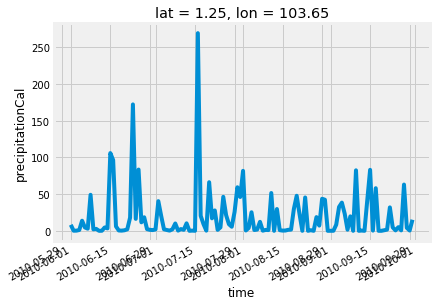

In [10]:
gpm_sampled = gpm_dataset.sel(lon=103.68, lat=1.30, method='nearest').resample(time='1D').sum()
# gpm_sampled['precipitationCal'].plot()
gpm_sampled.sel(time=slice('2010-06-01T00:0','2010-09-30T00:0'))['precipitationCal'].plot()

### Parsing the IMAGER dataset

In [11]:
# Parsing the Dates
imager_rainfall_df['date']=pd.to_datetime(imager_rainfall_df['day'], unit='D', origin=pd.Timestamp('2009-12-31')) # Using day number to create the date
imager_rainfall_df['timestamp'] = imager_rainfall_df['date'] + pd.to_timedelta(imager_rainfall_df['hour'].astype('str') + ':' + imager_rainfall_df['minute'].astype('str') + ':00') # append the timedelta in hours and minutes to get the full timestamp
imager_rainfall_df.set_index('timestamp', inplace=True)

In [12]:
imager_sampled_df = pd.DataFrame()
imager_sampled_df = imager_rainfall_df.groupby(pd.Grouper(freq="M")).resample('D').sum() # Groupby MONTH and then taking the total daily sum
imager_sampled_df.drop(['day', 'hour', 'minute'], axis=1, inplace=True) # Dropped the day, hour, minute columns
imager_sampled_df = imager_sampled_df.reset_index(level=0, drop=True)
imager_sampled_df['rainfall_rate'] = imager_sampled_df['rainfall_rate']/100 # downscaled by 100
imager_sampled_df.head() # Imager Data after resampling

,rainfall_rate
timestamp,
2010-01-01,10.80
2010-01-02,0.12
2010-01-03,0.12
2010-01-04,7.92
2010-01-05,0.00


In [13]:
def plot_monthly_data():
    titles = ["January 2010", "February 2010", "March 2010", "April 2010", "May 2010", "June 2010", "July 2010", "August 2010", "September 2010", "October 2010", "November 2010", "December 2010"]
    for i in range(1, 13):
        plt.figure()
        plt.plot(sampled_df[sampled_df.index.month == i]['rainfall_rate'])
        plt.title(titles[i-1], loc='left')
        plt.xlabel('Timestamp')
        plt.ylabel('Rainfall Rate in ')
        # Show/save figure as desired.
        plt.show()
# plot_monthly_data()

### Basic data analysis for the IMAGER data

In [14]:
# daily_statistics_df = pd.DataFrame()
# monthly_statistics_df = pd.DataFrame()
# daily_statistics_df['daily_total_rate'] = rainfall_df.rainfall_rate.resample('D').sum()
# daily_statistics_df['daily_mean_rate'] = rainfall_df.rainfall_rate.resample('D').mean()
# monthly_statistics_df['monthly_total_rate'] = rainfall_df.rainfall_rate.resample('M').sum()
# monthly_statistics_df['monthly_mean_rate'] = rainfall_df.rainfall_rate.resample('M').mean()

In [15]:
# plt.plot(monthly_statistics_df['monthly_mean_rate'] )
# plt.title("Monthly Mean rainfall from IMAGER, 2010", loc='left')
# plt.xlabel('Timestamp')
# plt.ylabel('Mean Rainfall')
# ax = plt.gca()
# locator = mdates.MonthLocator()
# month_fmt = mdates.DateFormatter('%b')
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(month_fmt)

## January Rainfall Comparison with Gauge Station Data
Taken from - www.weather.gov.sg/climate-historical-daily/

NOTE : The Imager Raifall Column is divided by 100, in order to fit it with Gauge Station Data. After knowing the actual units of the data it would be corrected.

In [16]:
# Separate Dataframes for January
imager_jan = imager_sampled_df.loc[imager_sampled_df.index.month == 1]/100
gauge_jan = gauge_station_df.loc[gauge_station_df.index.month == 1]

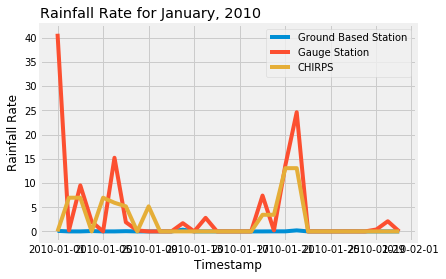

In [17]:
fig1 = plt.figure()
figures.append(fig1)
plt.plot(imager_jan['rainfall_rate'], label='Ground Based Station')
plt.plot(gauge_jan['rainfall_rate'], label='Gauge Station')
plt.plot(chirps_df['precip'], label='CHIRPS')
plt.title('Rainfall Rate for January, 2010', loc='left')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Rainfall Rate');

## Monsoon Season Analysis -
According to [this](https://www.guidemesingapore.com/business-guides/immigration/get-to-know-singapore/weather-and-climate-in-singapore),
There is no clear-cut wet or dry season and rain is experienced every single month, usually in the afternoons and early evenings. However, there are two main monsoon seasons in Singapore: **Northeast Monsoon Season (December-March) and the Southwest Monsoon Season (June-September)**.

In [18]:
monsoon_imager = imager_sampled_df[(imager_sampled_df.index.month >= 6) & (imager_sampled_df.index.month <= 9)]
monsoon_gauge = gauge_station_df[(gauge_station_df.index.month >= 6) & (gauge_station_df.index.month <= 9)]
monsoon_gauge = monsoon_gauge.sort_index(axis=0)
monsoon_gpm = gpm_sampled.sel(time=slice('2010-06-01T00:0','2010-09-30T00:0')).to_dataframe()
monsoon_imager

,rainfall_rate
timestamp,
2010-06-01,0.36
2010-06-02,20.40
2010-06-03,0.00
2010-06-04,10.56
2010-06-05,3.00
...,...
2010-09-26,0.00
2010-09-27,2.04
2010-09-28,0.12


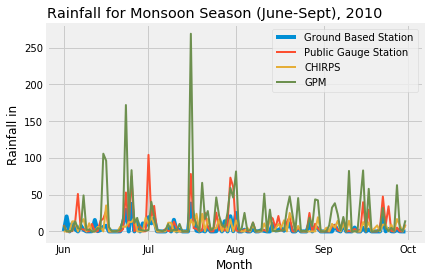

In [19]:
# fig2 = plt.figure()
# figures.append(fig2)
plt.plot(monsoon_imager['rainfall_rate'], label='Ground Based Station')
plt.plot(monsoon_gauge['rainfall_rate'], linewidth=2, label='Public Gauge Station')
plt.plot(monsoon_chirps_df['precip'], label='CHIRPS', linewidth=2)
plt.plot(monsoon_gpm['precipitationCal'], linewidth=2, label="GPM")
plt.title('Rainfall for Monsoon Season (June-Sept), 2010', loc='left')
plt.xlabel("Month")
plt.ylabel("Rainfall in ")
ax = plt.gca()
locator = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(month_fmt)
plt.legend();

The points are more or less aligned, therefore the IMAGER is giving good aproximates for larger amount of rainfall. It will be more coherant when the units of IMAGER is known.

### Monsoon Season Comparison Distribution Plot

/Users/dhirajsaharia/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


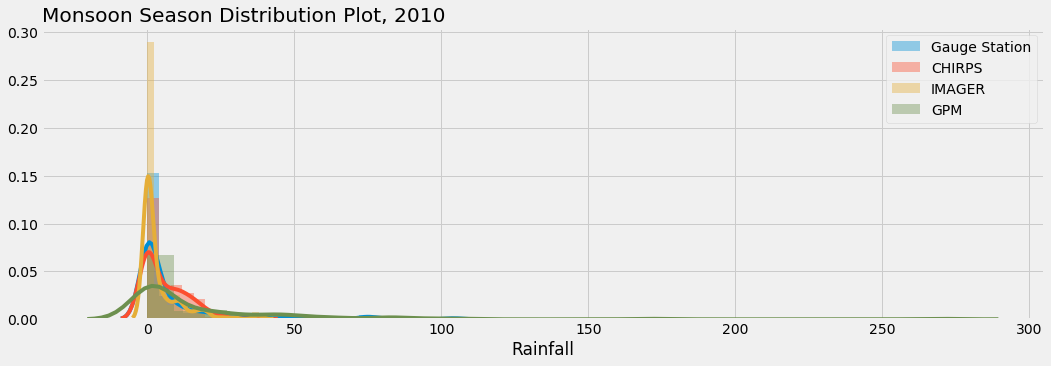

In [38]:
sns.distplot(monsoon_gauge['rainfall_rate'], hist=True, kde=True, label='Gauge Station')
sns.distplot(monsoon_chirps_df['precip'], hist=True, kde=True, label='CHIRPS')
sns.distplot(monsoon_imager['rainfall_rate'], hist=True, kde=True, label='IMAGER')
sns.distplot(monsoon_gpm['precipitationCal'], hist=True, kde=True, label='GPM')
plt.legend()
plt.title('Monsoon Season Distribution Plot, 2010', loc="left")
plt.xlabel("Rainfall");

In [21]:
# corr = monsoon_gauge['rainfall'].corr(monsoon_precip_df['precip'], method='pearson')
# corr

In [22]:
# chirps_mean = precip_dataset['precip'].sel(time=slice('2010-01-01T00:0','2010-12-31T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()

In [23]:
# fig_to_pdf(figures)

In [24]:
imager_jan.corrwith(gauge_jan, method='pearson')

rainfall_rate    0.367613
dtype: float64

In [25]:
monsoon_imager.corrwith(monsoon_gauge, method='pearson')

rainfall_rate    0.616719
dtype: float64

In [26]:
monsoon_gauge.corrwith(monsoon_chirps_df['precip'], method='pearson')

rainfall_rate    0.227545
dtype: float64

## Correlation Calculation
---

In [27]:
print(f"Correlation of Base Station with Gauge station data {monsoon_imager.corrwith(monsoon_gauge, method='pearson').values}")
print(f"Correlation of Base Station with GPM dataset {monsoon_imager.corrwith(monsoon_gpm['precipitationCal'], method='pearson').values}")
print(f"Correlation of Base Station with CHIRPS {monsoon_imager.corrwith(monsoon_chirps_df['precip'], method='pearson').values}")      

Correlation of Base Station with Gauge station data [0.61671942]
Correlation of Base Station with GPM dataset [0.59278394]
Correlation of Base Station with CHIRPS [0.27483112]


In [74]:
pd.merge(monsoon_imager, monsoon_gauge, on='timestamp').resample('1M')[['rainfall_rate_x', 'rainfall_rate_y']].corr().groupby(level=0).first()

,rainfall_rate_x,rainfall_rate_y
timestamp,,
2010-06-30,1.0,0.609486
2010-07-31,1.0,0.659257
2010-08-31,1.0,0.397254
2010-09-30,1.0,0.729701


Text(0.5, 0, 'CHIRPS')

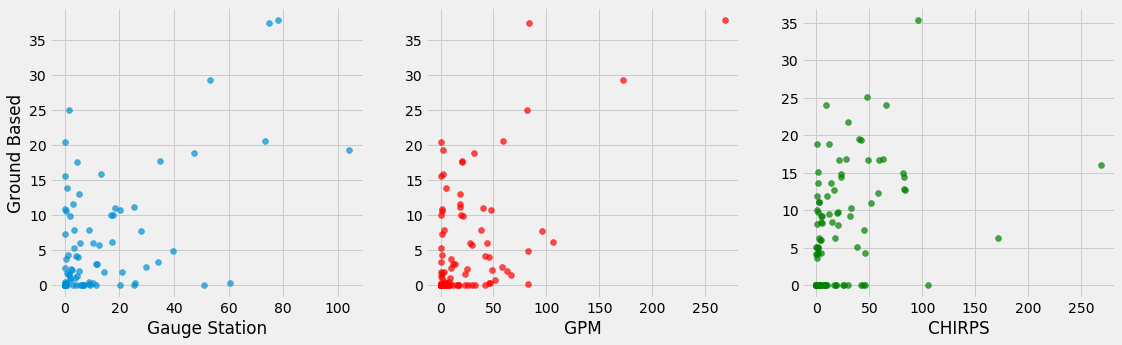

In [70]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.scatter(monsoon_gauge['rainfall_rate'], monsoon_imager['rainfall_rate'], alpha=0.7)
plt.xlabel('Gauge Station')
plt.ylabel('Ground Based')
plt.subplot(1,3,2)
plt.scatter(monsoon_gpm['precipitationCal'], monsoon_imager['rainfall_rate'], alpha=0.7, c='r')
plt.xlabel('GPM')
plt.subplot(1,3,3)
plt.scatter(monsoon_gpm['precipitationCal'], monsoon_chirps_df['precip'], alpha=0.7, c='g')
plt.xlabel('CHIRPS');